In [ ]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
print(f"Global seed set to {seed}")

In [ ]:
!wandb login 8285c1e86ba66976957cd9bdbae9e646b37bba8f

In [ ]:
# !git clone https://github.com/ayannareda/Weather-Detection-Using-Images.git
# url - /kaggle/working/Weather-Detection-Using-Images/Data

### Dataset Loader

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms

class ImageFilenameDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = []
        for label_name in os.listdir(root):
            label_dir = os.path.join(root, label_name)
            if os.path.isdir(label_dir) and label_name.isdigit():
                for fname in sorted(os.listdir(label_dir)):
                    if fname.lower().endswith(('.jpg', '.png')):
                        path = os.path.join(label_dir, fname)
                        self.files.append((path, int(label_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

### Model Architecture


In [1]:
# StarGAN Generator with ResNet blocks and Self-Attention
import torch.nn as nn
import torch

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1), nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim,    1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.size()
        # project
        proj_q = self.query(x).view(b, -1, h*w).permute(0,2,1)   # (B, H*W, C//8)
        proj_k = self.key(x).view(b, -1, h*w)                    # (B, C//8, H*W)
        attn   = torch.softmax(torch.bmm(proj_q, proj_k), dim=-1)  # (B, H*W, H*W)
        proj_v = self.value(x).view(b, -1, h*w)                  # (B, C, H*W)

        # original self‐attended output
        out = torch.bmm(proj_v, attn.permute(0,2,1)).view(b, c, h, w)
        out = self.gamma * out + x

        # compute a single‐channel spatial attention map
        # sum over *source* locations for each *target* pixel
        attn_map = attn.sum(dim=1).view(b, 1, h, w)  # (B,1,H,W)
        # normalize to [0,1]
        attn_map = attn_map / (attn_map.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] + 1e-8)

        # element‐wise multiply so that high‐attn regions are amplified
        out = out * (1 + attn_map)

        return out

class Generator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5, n_blocks=6):
        super().__init__()
        self.n_classes = n_classes
        # initial conv
        model = [nn.Conv2d(in_ch + n_classes, 64, 7, 1, 3), nn.InstanceNorm2d(64), nn.ReLU()]
        # downsample
        dim = 64
        for _ in range(2):
            model += [nn.Conv2d(dim, dim*2, 4, 2, 1), nn.InstanceNorm2d(dim*2), nn.ReLU()]
            dim *= 2
        # ResNet blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(dim)]
        # insert self-attention layer to focus on weather regions
        model += [SelfAttention(dim)]
        # upsample
        for _ in range(2):
            model += [nn.ConvTranspose2d(dim, dim//2, 4, 2, 1), nn.InstanceNorm2d(dim//2), nn.ReLU()]
            dim //= 2
        # final conv
        model += [nn.Conv2d(dim, in_ch, 7, 1, 3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x, target_label):
        # target_label: one-hot tensor of shape (B, n_classes)
        b, _, h, w = x.size()
        label_map = target_label.view(b, self.n_classes, 1, 1).expand(b, self.n_classes, h, w)
        inp = torch.cat([x, label_map], dim=1) # [B, in_ch + n_classes, h, w]
        return self.model(inp) # [B, in_ch, h, w]

In [2]:
# StarGAN Discriminator with adversarial and classification heads
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_ch=3, n_classes=5):
        super().__init__()
        layers = []
        dim = in_ch
        for out_dim in [64, 128, 256, 512]:
            layers += [nn.Conv2d(dim, out_dim, 4, 2, 1), nn.LeakyReLU(0.01)]
            dim = out_dim
        self.main = nn.Sequential(*layers)
        self.adv_head = nn.Conv2d(512, 1, 3, 1, 1)
        self.cls_head = nn.Conv2d(512, n_classes, 3, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        h       = self.main(x)           # [B,512,H',W']
        out_adv = self.adv_head(h)       # [B,1, H',W']
        out_cls = self.cls_head(h)       # [B,n_classes,H',W']
        out_cls = self.global_pool(out_cls)  # [B,n_classes,1,1]
        out_cls = out_cls.view(h.size(0), -1)  # [B,n_classes]
        return out_adv, out_cls

### Training Loop

In [ ]:
from tqdm import tqdm
import os
import torch.nn.functional as F
import numpy as np
import torchvision.models as models
from pytorch_msssim import ssim
import wandb

# Perceptual model (VGG19 features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg19(pretrained=True).features[:16].to(device).eval()
for p in vgg.parameters(): p.requires_grad = False

def perceptual_loss_fn(x, y):
    fx = vgg(x)
    fy = vgg(y)
    return torch.nn.functional.l1_loss(fx, fy)

# Gram matrix and style loss
def gram_matrix(feat):
    (b, c, h, w) = feat.size()
    feat = feat.view(b, c, h * w)
    gram = torch.bmm(feat, feat.transpose(1, 2)) / (c * h * w)
    return gram

def gram_loss_fn(x, y):
    fx = vgg(x)
    fy = vgg(y)
    gram_x = gram_matrix(fx)
    gram_y = gram_matrix(fy)
    return torch.nn.functional.l1_loss(gram_x, gram_y)

# Hinge loss for GANs
def d_hinge_loss(real_logits, fake_logits):
    loss_real = torch.mean(F.relu(1. - real_logits))
    loss_fake = torch.mean(F.relu(1. + fake_logits))
    return loss_real + loss_fake

def g_hinge_loss(fake_logits):
    return -torch.mean(fake_logits)

def train(G, D, train_loader, val_loader, optim_G, optim_D, device,
          epochs=50, lambda_cls=1.0, lambda_rec=10.0,
          lambda_perc=0.3, lambda_ssim=1.0, lambda_gram=0.2,
          checkpoint_dir='checkpoints', resume_path=None):
    # initialize metrics storage
    metrics = {
        'train_adv': [], 'train_cls': [], 'train_rec': [], 'train_perc': [], 'train_ssim': [], 'train_gram': [],
        'val_adv':   [], 'val_cls':   [], 'val_rec':   [], 'val_perc':   [], 'val_ssim':   [], 'val_gram': []
    }
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    # -- resume if provided --
    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=device)
        G.load_state_dict(ckpt['G_state']); D.load_state_dict(ckpt['D_state'])
        optim_G.load_state_dict(ckpt['optim_G_state'])
        optim_D.load_state_dict(ckpt['optim_D_state'])
        start_epoch = ckpt.get('epoch', 1) + 1
        print(f"Resuming from epoch {start_epoch}")

    cls_criterion = torch.nn.CrossEntropyLoss()
    rec_criterion = torch.nn.L1Loss()
    G.to(device); D.to(device)

    for epoch in range(start_epoch, epochs+1):
        G.train(); D.train()
        train_stats = {'adv': [], 'cls': [], 'rec': [], 'perc': [], 'ssim': [], 'gram': []}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for real_x, real_lbl in pbar:
            real_x, real_lbl = real_x.to(device), real_lbl.to(device)
            B = real_x.size(0)
            idx = torch.randperm(B); target_lbl = real_lbl[idx]
            target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            # Discriminator
            fake_x = G(real_x, target_oh).detach()
            optim_D.zero_grad()
            real_adv, real_cls = D(real_x)
            fake_adv, _ = D(fake_x)
            loss_D_adv = d_hinge_loss(real_adv, fake_adv)
            loss_D_cls = lambda_cls * cls_criterion(real_cls, real_lbl)
            loss_D = loss_D_adv + loss_D_cls
            loss_D.backward(); optim_D.step()

            # Generator
            optim_G.zero_grad()
            fake_x = G(real_x, target_oh)
            adv_out, cls_out = D(fake_x)
            rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
            rec_x = G(fake_x, rec_lbl_oh)
            perc_loss = perceptual_loss_fn(fake_x, real_x)
            gram_loss = gram_loss_fn(fake_x, real_x)
            ssim_loss = 1 - ssim(fake_x, real_x, data_range=1.0, size_average=True)
            loss_G_adv = g_hinge_loss(adv_out)
            loss_G_cls = lambda_cls * cls_criterion(cls_out, target_lbl)
            loss_G_rec = lambda_rec * rec_criterion(rec_x, real_x)
            loss_G_perc = lambda_perc * perc_loss
            loss_G_gram = lambda_gram * gram_loss
            loss_G_ssim = lambda_ssim * ssim_loss
            loss_G = loss_G_adv + loss_G_cls + loss_G_rec + loss_G_perc + loss_G_gram + loss_G_ssim
            loss_G.backward(); optim_G.step()

            # collect stats
            train_stats['adv'].append(loss_G_adv.item())
            train_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
            train_stats['rec'].append(rec_criterion(rec_x, real_x).item())
            train_stats['perc'].append(perc_loss.item())
            train_stats['ssim'].append((1 - ssim_loss).item())
            train_stats['gram'].append(gram_loss.item())
            pbar.set_postfix({k: np.mean(v) for k, v in train_stats.items()})

        # Validation
        G.eval(); D.eval()
        val_stats = {'adv': [], 'cls': [], 'rec': [], 'perc': [], 'ssim': [], 'gram': []}
        with torch.no_grad():
            vbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
            for real_x, real_lbl in vbar:
                real_x, real_lbl = real_x.to(device), real_lbl.to(device)
                B = real_x.size(0)
                idx = torch.randperm(B); target_lbl = real_lbl[idx]
                target_oh = F.one_hot(target_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                fake_x = G(real_x, target_oh)
                adv_out, cls_out = D(fake_x)
                rec_lbl_oh = F.one_hot(real_lbl, G.module.n_classes if isinstance(G, torch.nn.DataParallel) else G.n_classes).float().to(device)
                rec_x = G(fake_x, rec_lbl_oh)
                val_perc = perceptual_loss_fn(fake_x, real_x)
                val_gram = gram_loss_fn(fake_x, real_x)
                val_ssim = ssim(fake_x, real_x, data_range=1.0, size_average=True)
                val_stats['adv'].append(g_hinge_loss(adv_out).item())
                val_stats['cls'].append(cls_criterion(cls_out, target_lbl).item())
                val_stats['rec'].append(rec_criterion(rec_x, real_x).item())
                val_stats['perc'].append(val_perc.item())
                val_stats['ssim'].append(val_ssim.item())
                val_stats['gram'].append(val_gram.item())
                vbar.set_postfix({k: np.mean(v) for k, v in val_stats.items()})

        # Log metrics
        print(f"Epoch {epoch}: Train -> adv={np.mean(train_stats['adv']):.4f}, ",
              f"cls={np.mean(train_stats['cls']):.4f}, rec={np.mean(train_stats['rec']):.4f}, perc={np.mean(train_stats['perc']):.4f}, gram={np.mean(train_stats['gram']):.4f}, ssim={np.mean(train_stats['ssim']):.4f}")
        print(f"           Val   -> adv={np.mean(val_stats['adv']):.4f}, ",
              f"cls={np.mean(val_stats['cls']):.4f}, rec={np.mean(val_stats['rec']):.4f}, perc={np.mean(val_stats['perc']):.4f}, gram={np.mean(val_stats['gram']):.4f}, ssim={np.mean(val_stats['ssim']):.4f}")

        # wandb logging
        wandb.log({
            'epoch': epoch,
            'train/adv': np.mean(train_stats['adv']),
            'train/cls': np.mean(train_stats['cls']),
            'train/rec': np.mean(train_stats['rec']),
            'train/perc': np.mean(train_stats['perc']),
            'train/ssim': np.mean(train_stats['ssim']),
            'train/gram': np.mean(train_stats['gram']),
            'val/adv': np.mean(val_stats['adv']),
            'val/cls': np.mean(val_stats['cls']),
            'val/rec': np.mean(val_stats['rec']),
            'val/perc': np.mean(val_stats['perc']),
            'val/ssim': np.mean(val_stats['ssim']),
            'val/gram': np.mean(val_stats['gram'])
        })

        # Save checkpoint
        if epoch % 5 == 0 or epoch == epochs:
            ckpt_path = os.path.join(checkpoint_dir, f"ckpt_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'G_state': G.state_dict(),
                'D_state': D.state_dict(),
                'optim_G_state': optim_G.state_dict(),
                'optim_D_state': optim_D.state_dict()
            }, ckpt_path)
        # append epoch metrics
        metrics['train_adv'].append(np.mean(train_stats['adv']))
        metrics['train_cls'].append(np.mean(train_stats['cls']))
        metrics['train_rec'].append(np.mean(train_stats['rec']))
        metrics['train_perc'].append(np.mean(train_stats['perc']))
        metrics['train_ssim'].append(np.mean(train_stats['ssim']))
        metrics['train_gram'].append(np.mean(train_stats['gram']))
        metrics['val_adv'].append(np.mean(val_stats['adv']))
        metrics['val_cls'].append(np.mean(val_stats['cls']))
        metrics['val_rec'].append(np.mean(val_stats['rec']))
        metrics['val_perc'].append(np.mean(val_stats['perc']))
        metrics['val_ssim'].append(np.mean(val_stats['ssim']))
        metrics['val_gram'].append(np.mean(val_stats['gram']))
    # end epochs
    return metrics

In [ ]:
# !pip install wandb pytorch-msssim

In [ ]:
import torch.nn as nn
# Example usage of train_starGAN function
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate models
G = Generator().to(device)
D = Discriminator().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)

# Optimizers
optim_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Create dataset and split into train and validation sets
BATCH_SIZE = 32
dataset = ImageFilenameDataset('/kaggle/working/Weather-Detection-Using-Images/Data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Initialize wandb
wandb.init(project='WeatherGAN', name='stargan-perceptual-sa', 
    # resume= "allow",
    # id='hvrmqj65',
    config={
    'epochs': 80,
    'batch_size': BATCH_SIZE,
    'lr': 2e-4,
    'lambda_cls': 1.0,
    'lambda_rec': 10.0,
    'lambda_perc': 0.5,
    'lambda_ssim': 0.6,
    'lambda_gram': 0.1
})

# Call train_starGAN function
metrics = train(
    G, D,
    train_loader, val_loader,
    optim_G, optim_D,
    device,
    epochs=80,
    checkpoint_dir='checkpoints/perceptual/v1',
    # resume_path="checkpoints/perceptual/sa_ckpt_epoch_40.pt"
)

# No need to save metrics as .pkl, all metrics are logged to wandb

In [ ]:
!ls ./checkpoints/perceptual

---

In [ ]:
!ls

## Inference time

/tmp/ipykernel_71/949148812.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('./checkpoints/perceptual/sa_ckpt_epoch_45.pt', map_location=device)


Using 2 GPUs


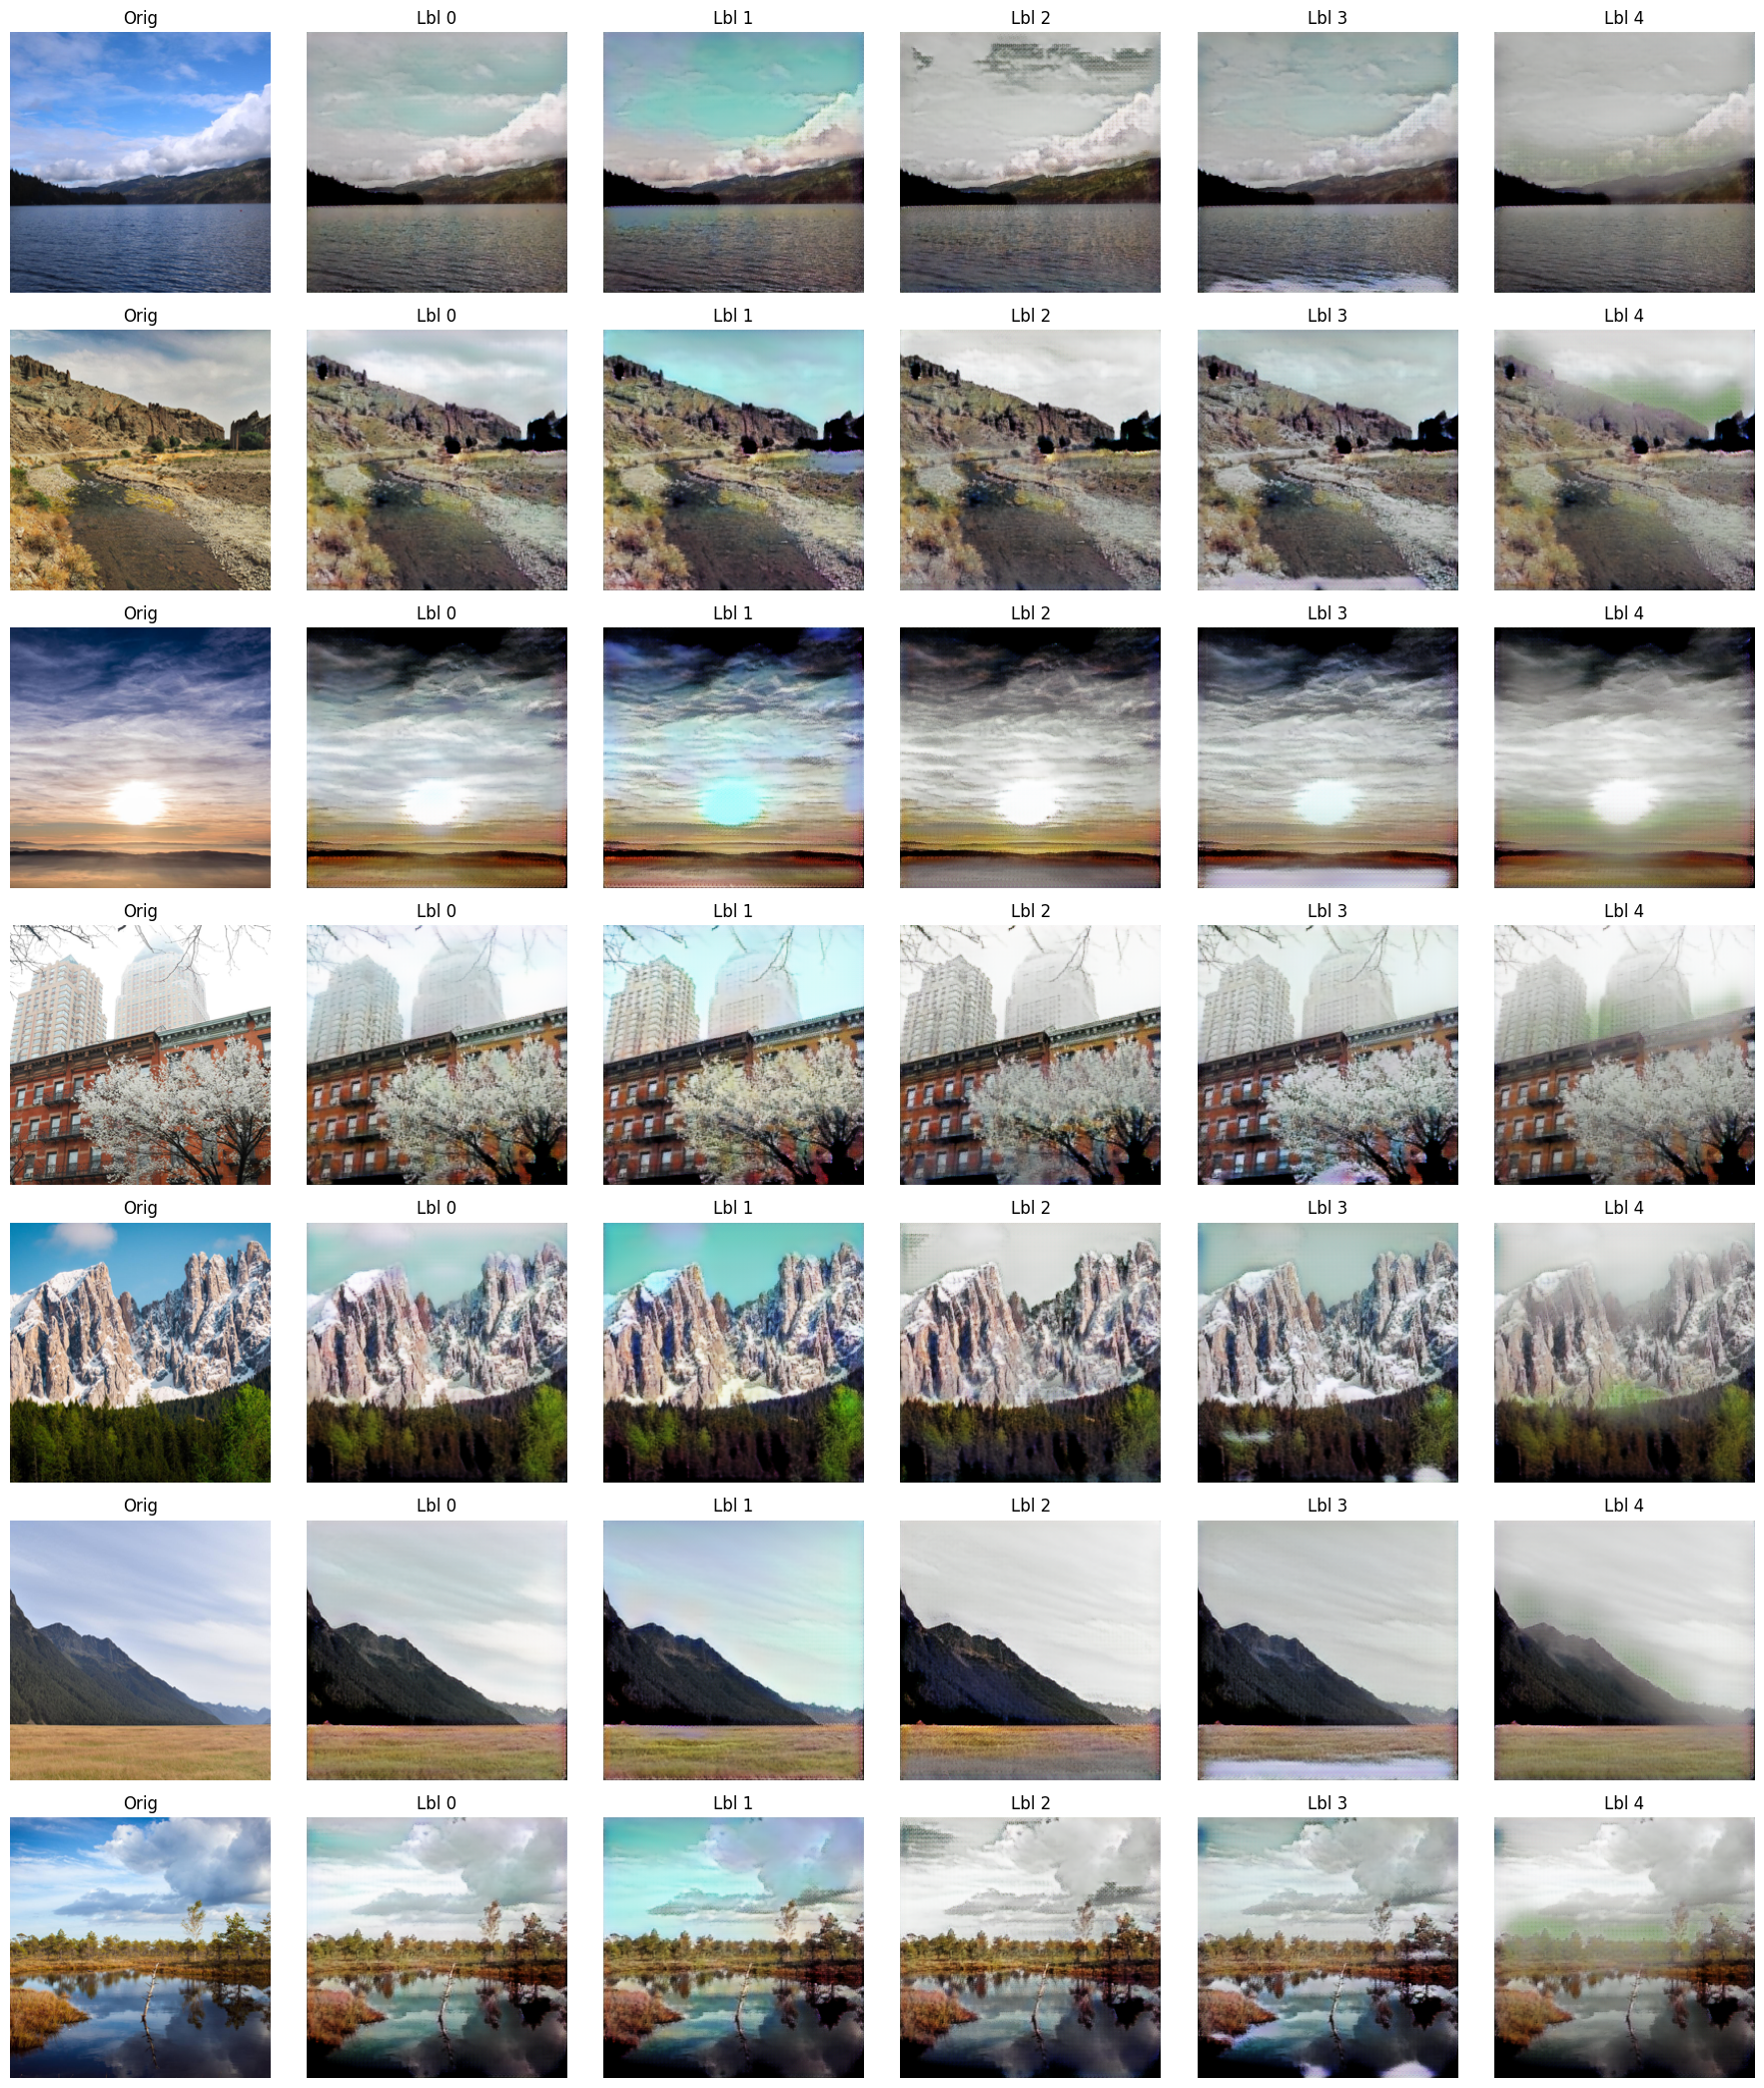

In [ ]:
# Inference for 10 images from class '0' and all target labels
import torch
import os
import random
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) define transforms (must match training)
transform_in = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# 2) helper to undo Normalize
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std =[2.0,  2.0,  2.0]
)

# 3) load checkpoint & build model
ckpt = torch.load('./checkpoints/perceptual/sa_ckpt_epoch_45.pt', map_location=device)
# If model was trained with DataParallel, wrap before loading state dict

G = Generator().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    G = nn.DataParallel(G)
G.load_state_dict(ckpt['G_state'])
G.eval()

# 4) inference function
def infer(img_path, target_label):
    img = Image.open(img_path).convert('RGB')
    x = transform_in(img).unsqueeze(0).to(device)
    lbl = torch.tensor([target_label], device=device)
    # handle DataParallel vs single‐GPU
    num_classes = G.module.n_classes if hasattr(G, 'module') else G.n_classes
    lbl_onehot = F.one_hot(lbl, num_classes=num_classes).float().to(device)
    with torch.no_grad():
        fake = G(x, target_label=lbl_onehot)
    # undo normalization & clamp
    fake = unnormalize(fake.squeeze(0).cpu()).clamp(0,1)
    return img, transforms.ToPILImage()(fake)

# Inference for 10 images from class '0' and all target labels
# base_path = '/kaggle/working/Weather-Detection-Using-Images/Data'
# dir0 = os.path.join(base_path, '2')
dir0 = "/kaggle/input/lhq-1024/dataset"
files0 = sorted([f for f in os.listdir(dir0) if f.lower().endswith(('.jpg', '.png'))])
files0 = random.sample(files0, min(7, len(files0)))
num_labels = G.module.n_classes if hasattr(G, 'module') else G.n_classes
fig, axes = plt.subplots(len(files0), 1 + num_labels, figsize=(3*(1+num_labels), 3*len(files0)))
for i, fname in enumerate(files0):
    path = os.path.join(dir0, fname)
    img_orig = Image.open(path).convert('RGB')
    img_resized = img_orig.resize((256,256))
    axes[i, 0].imshow(img_resized); axes[i, 0].axis('off'); axes[i, 0].set_title('Orig')
    for lb in range(num_labels):
        _, gen = infer(path, target_label=lb)
        axes[i, lb+1].imshow(gen); axes[i, lb+1].axis('off'); axes[i, lb+1].set_title(f'Lbl {lb}')
plt.tight_layout(); plt.show()

In [4]:
!ls /kaggle/working/Weather-Detection-Using-Images/Data/2

108412030.jpg	2237755292.jpg	2774883291.jpg	3203624115.jpg	412665927.jpg
10.jpg		2238092127.jpg	2775372494.jpg	3204460790.jpg	412853226.jpg
1119608326.jpg	2239044863.jpg	2775392628.jpg	3204471456.jpg	4144090.jpg
112409018.jpg	2241096650.jpg	277621699.jpg	3208586645.jpg	414949570.jpg
11341139.jpg	2243175924.jpg	2780355555.jpg	3211539801.jpg	415347405.jpg
11341142.jpg	2247815537.jpg	2781323813.jpg	3218201339.jpg	415354980.jpg
113772340.jpg	2248935885.jpg	2784599835.jpg	321940153.jpg	42061942.jpg
1141743692.jpg	2250303008.jpg	2785756223.jpg	3222417396.jpg	42061977.jpg
118028918.jpg	2253208424.jpg	2786610492.jpg	3222442386.jpg	42061988.jpg
1193251058.jpg	2255002798.jpg	2786611312.jpg	3222507780.jpg	42062007.jpg
1193263818.jpg	2255252477.jpg	2789254566.jpg	3222508168.jpg	42062033.jpg
1200324257.jpg	2255861335.jpg	2794897894.jpg	3222937920.jpg	42062093.jpg
1202678807.jpg	2255861707.jpg	2796695923.jpg	3223224529.jpg	421844665.jpg
1204565261.jpg	2260595824.jpg	2799391115.jpg	3225200382.jpg	422